In [0]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, CuDNNLSTM
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np
import seaborn as sns; sns.set()
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:

import numpy as np
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from gensim.summarization import bm25
import nltk
import numpy as np
import random
import pickle
import scipy
import sklearn
import tqdm

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
#from keras.preprocessing import sequence
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation,concatenate,Embedding,LSTM,Conv1D,MaxPooling1D,Flatten,Input,Bidirectional,CuDNNLSTM
from keras.layers import Subtract,Lambda,Add

from keras.utils.vis_utils import model_to_dot	
from keras.utils import plot_model
from IPython.display import SVG
#SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [0]:
import keras 
import keras.backend as K
#def softmax_(x):
#  return keras.activations.softmax(x, axis=1)

def softmax(x, axis=1):
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

## MODEL

In [36]:
Tx=50
Ty=Tx
d=26
charachters=sorted(["b","c","d","f","g","h","j","k","l","m","n","p","q","r","s","t","v","w","x","y","z","a","e","i","o","u"])

vocab_size=len(charachters)
embedding_layer = Embedding(vocab_size + 1,d,input_length=Tx,trainable=True)

#attention parameters
reptor=RepeatVector(Tx)
dense1 = Dense(20,activation="tanh")
dense2 = Dense(1,activation="relu")
con=Concatenate(axis=-1)
dotor = Dot(axes = 1)
act_softmax=Activation(softmax)
####

def one_attention(lstm_outputs,a_prev):
  a_prev=reptor(a_prev)
  iii=con([a_prev,lstm_outputs])
  d1=dense1(iii)
  d2=dense2(d1)
  d2=act_softmax(d2)
  ret=dotor([d2,lstm_outputs])
  return ret,d2
#

##actual model
Inp=Input(shape=(Tx,))
e=embedding_layer(Inp)
input_lstm=Bidirectional(CuDNNLSTM(50,return_sequences=True),name="input_lstm")(e)

u=70
output_lstm_layer=CuDNNLSTM(u,return_state=True,name="output_lstm")
output_softmax =  Dense(vocab_size,activation=softmax)

outputs1=[]
outputs2=[]
a_i=Input(shape=(u,))
c_i=Input(shape=(u,))
a=a_i
c=c_i

for i in range(Ty):
  context,alphas=one_attention(input_lstm,a)
  a,_,c=output_lstm_layer(context,initial_state=[a,c])
  outputs1.append(output_softmax(a))
  outputs2.append(alphas)

model=Model(inputs=[Inp,a_i,c_i],outputs=outputs1)
tempmodel=Model(inputs=[Inp,a_i,c_i],outputs=outputs2)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 26)       702         input_7[0][0]                    
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 50, 70)       0           input_8[0][0]                    
                                                                 output_lstm[0][0]                
          

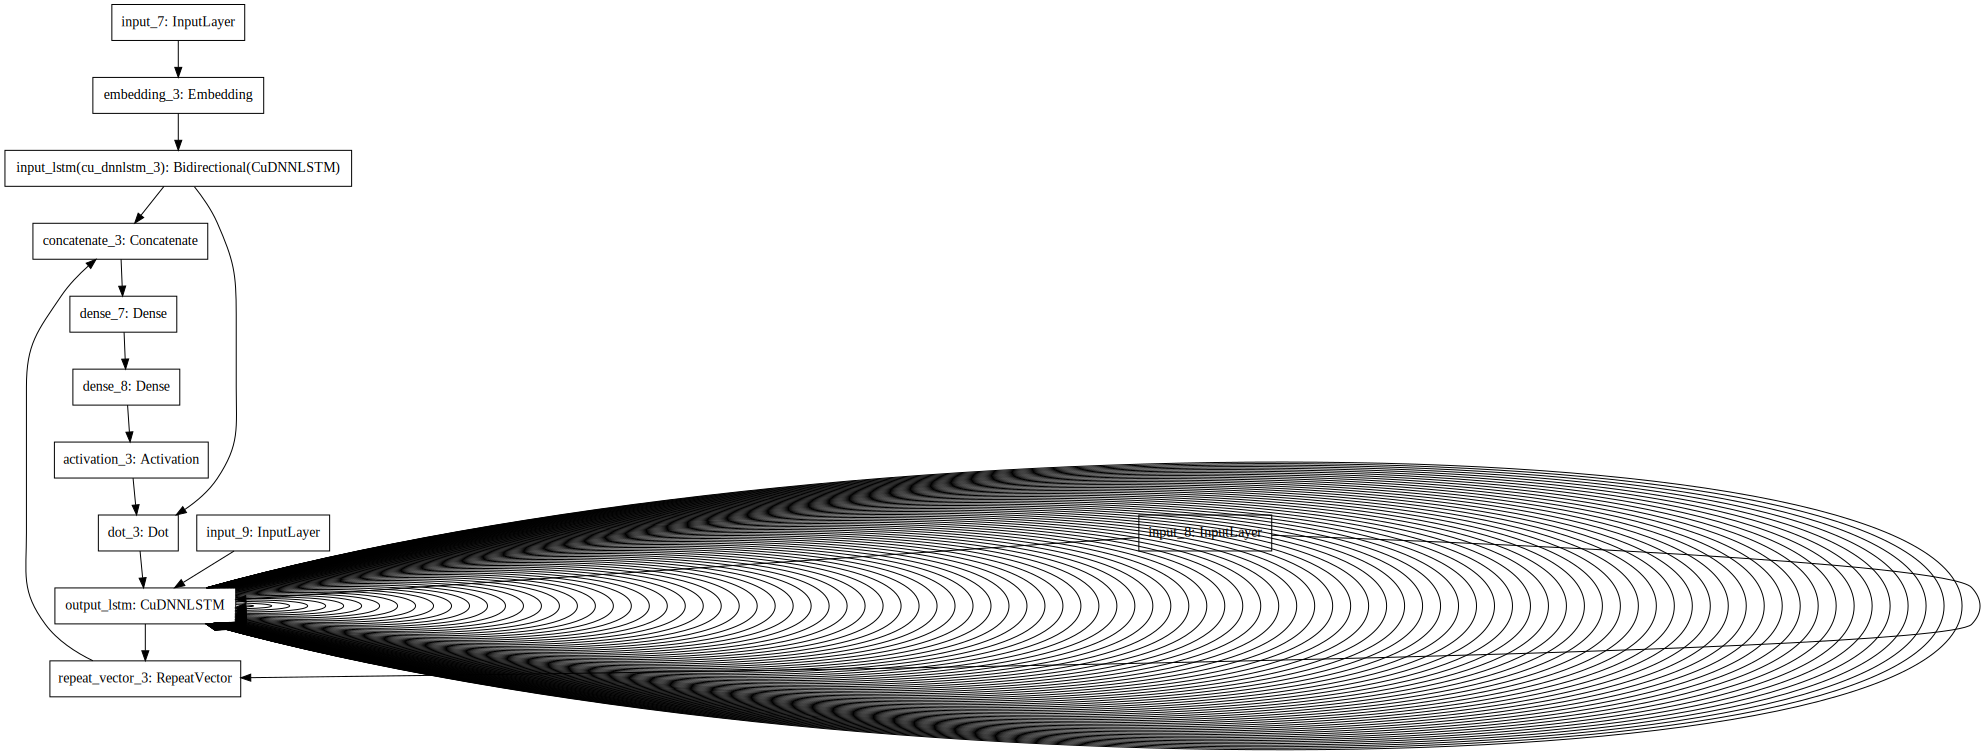

In [54]:
SVG(model_to_dot(tempmodel).create(prog='dot', format='svg'))

In [0]:
from keras.optimizers import Adam as adam
custom_adam=adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

model.compile(custom_adam,loss="categorical_crossentropy",metrics=["accuracy"])

### Create Training Testing Data from RAW sentences

In [0]:
##create 10 digit random charachter sequences
data_size=10000
rawdata=[random.sample(charachters*2,Tx) for i in range(data_size)]
reversedraw=[reversed(i) for i in rawdata]
seqdata=np.array([np.array([charachters.index(j) for j in i]) for i in rawdata])
reversedseqdata=np.array([np.array([charachters.index(j) for j in i]) for i in reversedraw])

In [40]:
seqdata,reversedseqdata

(array([[21, 15, 14, ..., 17, 13, 22],
        [ 7, 10, 15, ...,  1,  7,  5],
        [ 3, 15, 20, ..., 19, 20, 12],
        ...,
        [11, 20,  7, ..., 10,  3,  3],
        [ 9, 20,  6, ...,  7, 18,  5],
        [ 8, 12,  3, ..., 22, 20, 18]]), array([[22, 13, 17, ..., 14, 15, 21],
        [ 5,  7,  1, ..., 15, 10,  7],
        [12, 20, 19, ..., 20, 15,  3],
        ...,
        [ 3,  3, 10, ...,  7, 20, 11],
        [ 5, 18,  7, ...,  6, 20,  9],
        [18, 20, 22, ...,  3, 12,  8]]))

In [0]:
assert (seqdata == np.argmax(to_categorical(seqdata,num_classes=vocab_size),axis=-1)).all()

In [0]:
target=to_categorical(reversedseqdata).swapaxes(0,1)

In [44]:
history=model.fit([seqdata,np.zeros((data_size,u)),np.zeros((data_size,u))],list(target),epochs=200,batch_size=100, verbose=1)

10000/10000 [==============================] - 43s 4ms/step - loss: 13.9786 - dense_9_loss: 0.4509 - dense_9_acc: 0.9774 - dense_9_acc_1: 0.9340 - dense_9_acc_2: 0.9439 - dense_9_acc_3: 0.9418 - dense_9_acc_4: 0.9347 - dense_9_acc_5: 0.9381 - dense_9_acc_6: 0.9431 - dense_9_acc_7: 0.9475 - dense_9_acc_8: 0.9551 - dense_9_acc_9: 0.9560 - dense_9_acc_10: 0.9634 - dense_9_acc_11: 0.9667 - dense_9_acc_12: 0.9684 - dense_9_acc_13: 0.9712 - dense_9_acc_14: 0.9725 - dense_9_acc_15: 0.9751 - dense_9_acc_16: 0.9708 - dense_9_acc_17: 0.9698 - dense_9_acc_18: 0.9711 - dense_9_acc_19: 0.9680 - dense_9_acc_20: 0.9698 - dense_9_acc_21: 0.9694 - dense_9_acc_22: 0.9680 - dense_9_acc_23: 0.9724 - dense_9_acc_24: 0.9717 - dense_9_acc_25: 0.9691 - dense_9_acc_26: 0.9688 - dense_9_acc_27: 0.9676 - dense_9_acc_28: 0.9689 - dense_9_acc_29: 0.9735 - dense_9_acc_30: 0.9745 - dense_9_acc_31: 0.9724 - dense_9_acc_32: 0.9549 - dense_9_acc_33: 0.9411 - dense_9_acc_34: 0.9448 - dense_9_acc_35: 0.9541 - dense_9_acc

In [0]:
##create 10 digit random charachter sequences
Tdata_size=100
Trawdata=[random.sample(charachters*2,Tx) for i in range(Tdata_size)]
Tseqdata=np.array([np.array([charachters.index(j) for j in i]) for i in Trawdata])

In [0]:
def showresults(data):
  Tseqdata=np.array([np.array([charachters.index(j) for j in i]) for i in data])
  items=[]
  for ind,sample in enumerate(Tseqdata):
    ouput=model.predict([sample.reshape(1,Tx),np.zeros((1,u)),np.zeros((1,u))])
    ouput=np.array(ouput)
    ouput=np.argmax(ouput,axis=-1).reshape(1,Ty)[0]
    ouput="".join([charachters[int(j)] for j in ouput])
    iput="".join([i for i in data[ind]])
    items.append([iput,ouput])
  return items

In [107]:
showresults(Trawdata[:50])## Testing Data

[['tduqgukragwmtxirjbmplyfcjcyhsneoisfokqzdnahelvzwbp',
  'pbwzvlehandzqkofsioenshycjcfylpmbjrixtmwgarkugqudt'],
 ['ixswebvqvteljdotiwyguhgfjqxnlkrruzzdmpbysoahkfmncc',
  'ccnmfkhaosybpmdzzurrklnxqjfghugywitodjletvqvbewsxi'],
 ['ndyxzwvzdsmolirburkctxpukgqjfqcbselvgenfohwyapajmt',
  'tjjapaywhofnegvlesbcqfjqgkupxtckrubrilomsdzvwzxydn'],
 ['pfajslwhrtdhkubnzpxnbzqurlxkevjygwmvocgaitcmfiysoq',
  'qosyifmctiagcovmwgyjvekxlruqzbnxpznbukhdtrhwlsjafp'],
 ['nyctotqknduhkxbeawyjpfghvsrcsdxvjgozrpzemalmlfuibq',
  'qbiuflmlamezprzogjvxdscrsvhgfpjywaebxkhudnkqtotcyn'],
 ['sazdzceitogwvytvllakqpoqehdjpnkygujsufhnbmcwmrbxir',
  'iixbrmwcmbnhfusjugyknpjdheqopqkallvtyvwgotieczdzas'],
 ['gedosyhtcubftpaijqxambywvnwrjqxuvezknsomfilgdrhkcl',
  'cckhrdglifmosnkzevuxqjrwnvwybmaxqjiaptfbucthysodeg'],
 ['rptgspmrmefojyeciothabwkiqhndsfcngayvxuzlqxjdubvzk',
  'kzvbudjxqlzuxvyagncfsdnhqikwbahtoiceyjofemrmpsgtpr'],
 ['ufztcqlbgvjbqskczadhwpyykxhmrgoaridflnejsevnmiwupx',
  'xpuiimnvesjenlfdiraogrmhxkyypwhdazcks

In [108]:
showresults(rawdata[:50]) #Training Data

[['vpolcilyazudoussivjmdethwfgcqbnbaytphkgkexjrqxfrnw',
  'wnrfxqrjxekgkhptyabnbqcgfwhtedmjvissuoduzayliclopv'],
 ['hkpszlsmexttunrinlkjdqxazpcqfjwoaecvwggriyvmdubbhf',
  'fhbmddmvyirggwcceaowjfqcpzaxqdjklnirnuttxemslzspkh'],
 ['dpugeshgqwrsrjovdtxzezkonqykbpllymffchnaijiwacbtum',
  'mutbcawiuianhcffmyllpbkyqnokzezxtdvojrsrwqghsegupd'],
 ['ousunyqakhweqafrminvvcttmlxdbzjrzgspdflexwjiybocpg',
  'gpcobyijwxelfdpsgzrjzbdxlmttcvvnimrfaqewhkaqynusuo'],
 ['xghlwqrhpvyzisacqoxjfkelkbuabtwufnjcmrdyogivtzsepd',
  'dpesztvigoydrmcjnfuwtbaubklekfjxoqcasizyvphrqwlhgx'],
 ['cminwhktdrxmnzyqguflavbwperklujxcboztavipyofshejqs',
  'sqjehsfoypivatzobcxjulkrepwbvalfugqyznmxrdtkhwnimc'],
 ['pgbeqnwxjcsqudildkrkarfzbjfwgzcyahynpsohmttuvxlemv',
  'vmelxvuttmhospnyhayczgwfjbzfrakrkdliduqscjxwnqebgp'],
 ['mkaqltihoxorgfkbzjfehrqdbipumdnenvxstyzpylcuvwjwsg',
  'gswjwvuclypzytsxvnendmupibdqrhefjzbkfgroxohitlqakm'],
 ['jgkhdqidyrlyvnkqwrzcocalxftmugnvhjfpeutbmseaxozibs',
  'sbizoxaesmbtuepfjhvngumtfxlacoczrwqkn

In [49]:
len(rawdata)

10000

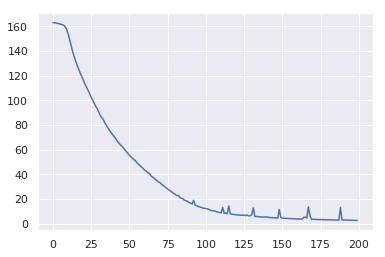

In [50]:
plt.plot(history.history["loss"])

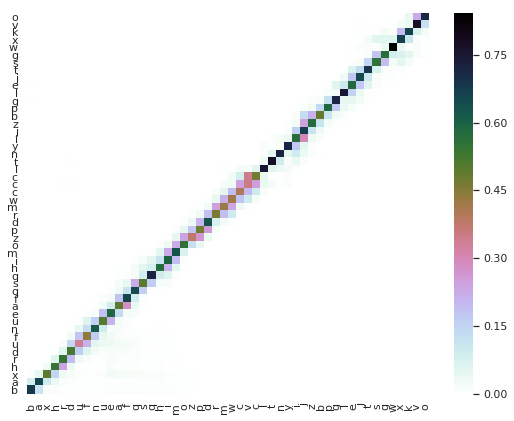

<Figure size 432x288 with 0 Axes>

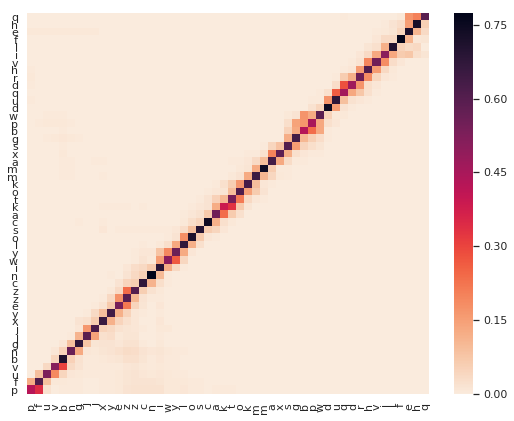

<Figure size 432x288 with 0 Axes>

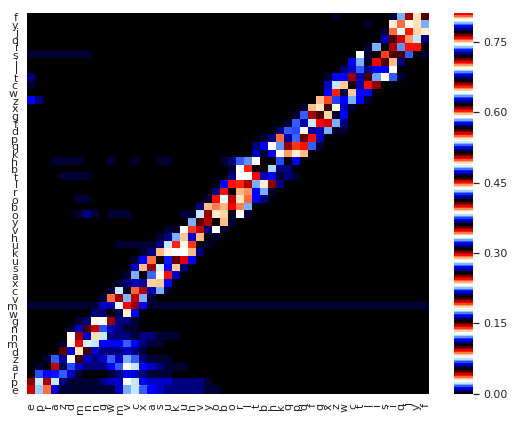

<Figure size 432x288 with 0 Axes>

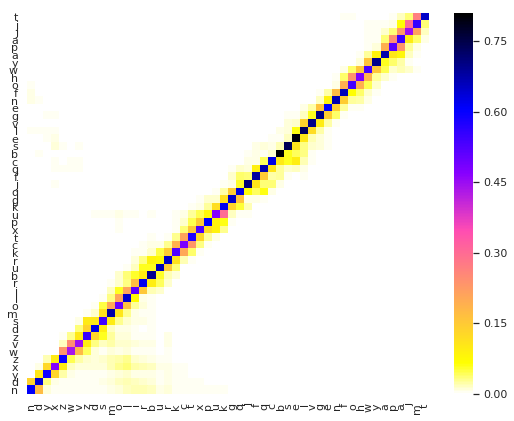

<Figure size 432x288 with 0 Axes>

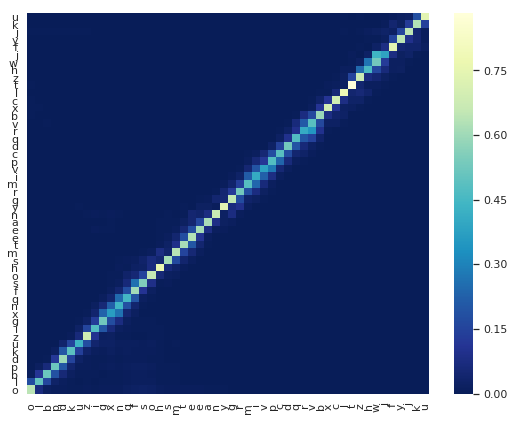

<Figure size 432x288 with 0 Axes>

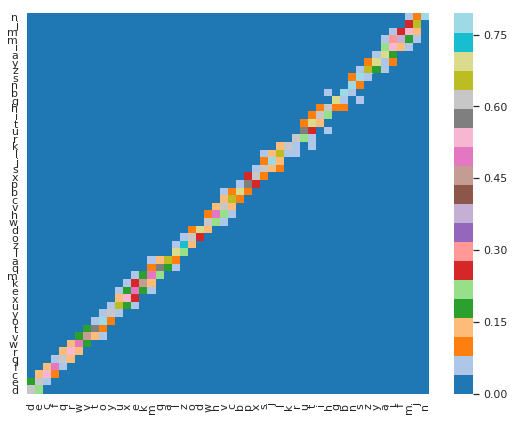

<Figure size 432x288 with 0 Axes>

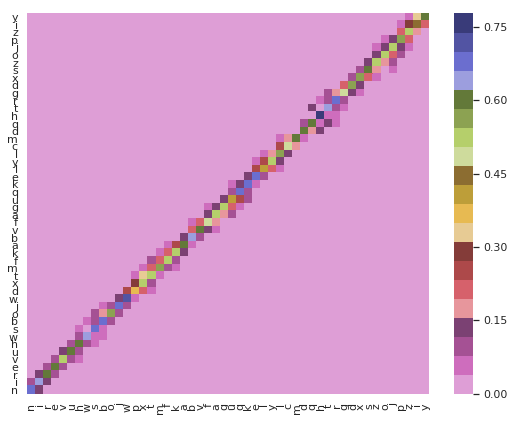

<Figure size 432x288 with 0 Axes>

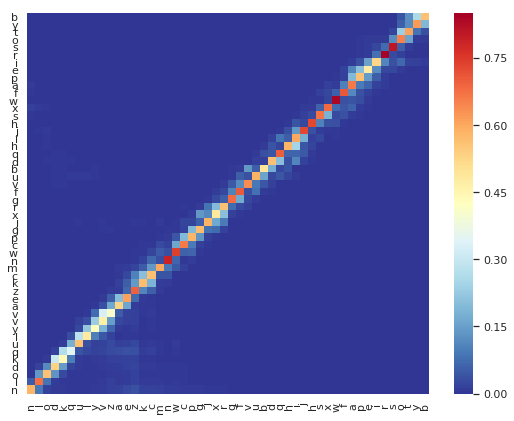

<Figure size 432x288 with 0 Axes>

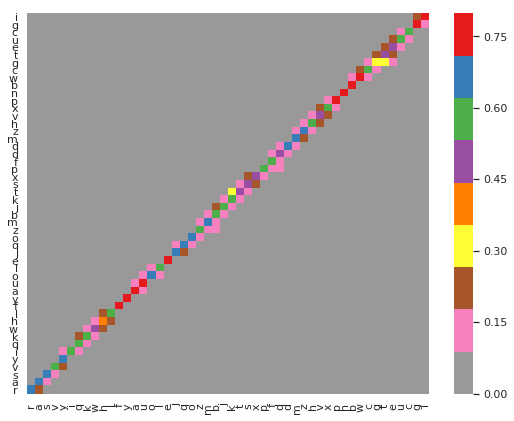

<Figure size 432x288 with 0 Axes>

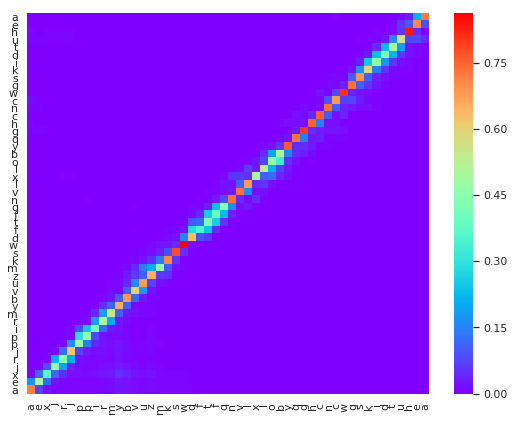

<Figure size 432x288 with 0 Axes>

In [106]:
for bs in  random.sample(range(1, 100), 10):        
  o=np.array(tempmodel.predict([Tseqdata[bs].reshape(1,Tx),np.zeros((1,u)),np.zeros((1,u))]))
  o=o.reshape(Ty,Tx)
  y=np.array(model.predict([Tseqdata[bs].reshape(1,Tx),np.zeros((1,u)),np.zeros((1,u))]))
  y=y.swapaxes(0,1)[0]
  y=np.argmax(y,axis=1)
  fig, ax = plt.subplots(figsize=(9,7))  
  xlabels= [charachters[j] for j in Tseqdata[bs]]
  ylabels=[charachters[j] for j in y]
  plt.xlabel("Input String")
  plt.ylabel("Output String")
  sns.heatmap(o,xticklabels=xlabels,yticklabels=ylabels,cmap=random.choice(["Accent","Accent_r","Blues","Blues_r","BrBG","BrBG_r","BuGn","BuGn_r","BuPu","BuPu_r","CMRmap","CMRmap_r","Dark2","Dark2_r","GnBu","GnBu_r","Greens","Greens_r","Greys","Greys_r","OrRd","OrRd_r","Oranges","Oranges_r","PRGn","PRGn_r","Paired","Paired_r","Pastel1","Pastel1_r","Pastel2","Pastel2_r","PiYG","PiYG_r","PuBu","PuBuGn","PuBuGn_r","PuBu_r","PuOr","PuOr_r","PuRd","PuRd_r","Purples","Purples_r","RdBu","RdBu_r","RdGy","RdGy_r","RdPu","RdPu_r","RdYlBu","RdYlBu_r","RdYlGn","RdYlGn_r","Reds","Reds_r","Set1","Set1_r","Set2","Set2_r","Set3","Set3_r","Spectral","Spectral_r","Wistia","Wistia_r","YlGn","YlGnBu","YlGnBu_r","YlGn_r","YlOrBr","YlOrBr_r","YlOrRd","YlOrRd_r","afmhot","afmhot_r","autumn","autumn_r","binary","binary_r","bone","bone_r","brg","brg_r","bwr","bwr_r","cividis","cividis_r","cool","cool_r","coolwarm","coolwarm_r","copper","copper_r","cubehelix","cubehelix_r","flag","flag_r","gist_earth","gist_earth_r","gist_gray","gist_gray_r","gist_heat","gist_heat_r","gist_ncar","gist_ncar_r","gist_rainbow","gist_rainbow_r","gist_stern","gist_stern_r","gist_yarg","gist_yarg_r","gnuplot","gnuplot2","gnuplot2_r","gnuplot_r","gray","gray_r","hot","hot_r","hsv","hsv_r","icefire","icefire_r","inferno","inferno_r","jet","jet_r","magma","magma_r","mako","mako_r","nipy_spectral","nipy_spectral_r","ocean","ocean_r","pink","pink_r","plasma","plasma_r","prism","prism_r","rainbow","rainbow_r","rocket","rocket_r","seismic","seismic_r","spring","spring_r","summer","summer_r","tab10","tab10_r","tab20","tab20_r","tab20b","tab20b_r","tab20c"]))
  plt.figure()

In [52]:
t = Tokenizer(num_words=3)
l = ["Hello, World! This is so&#$ fantastic!", "There is no other world like this one"]
t.fit_on_texts(l)
transform=t.texts_to_sequences(["Hello, world! This is so&#$ fantastic!", "There is no other world like this one"])
inv_map = {v: k for k, v in t.word_index.items()}
l=[]
for i in transform:
  tt=[]
  for j in i:
    tt.append(inv_map[j])
  l.append(tt)
l

[['world', 'this'], ['world', 'this']]